In [1]:
#RL
from tensorforce import Runner
from tensorforce import Environment
from tensorforce import Agent
#keras
import tensorflow as tf
#basic
import numpy as np
import pandas as pd
#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import balanced_accuracy_score
#image processing
from skimage.future import graph
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.segmentation import felzenszwalb
from skimage.morphology import closing, square
from skimage.color import label2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.transform import rescale
#visialization
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_palette("Set2")
#skmultiflow
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
from skmultiflow.rules import VeryFastDecisionRulesClassifier
from skmultiflow.trees import ExtremelyFastDecisionTreeClassifier
#scikit 
from scipy.spatial import distance_matrix
from scipy.spatial import distance
#graph
import networkx as nx
#ontology
import owlready2 as owl
#language model
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#dunn index
import dunn
from sklearn.metrics.pairwise import euclidean_distances
#other
from itertools import count
from joblib import dump, load

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
print(tf.__version__)

2.6.0


In [3]:
%load_ext tensorboard

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
#%tensorboard --logdir summaries/

In [6]:
States=np.load("Pong_Example_Run.npy")

# help functions

In [7]:
img=States[100]

In [10]:
def show_image(img):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)

In [11]:
def to_shape(a, shape, grayscale=True):
    y_, x_ = shape
    y, x = a.shape[0:2]
    y_pad = (y_-y)
    x_pad = (x_-x)
    if grayscale:
        return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                         (x_pad//2, x_pad//2 + x_pad%2)
                        ),
                      mode = 'constant')
    else:
        return np.pad(a,((y_pad//2, y_pad//2 + y_pad%2), 
                         (x_pad//2, x_pad//2 + x_pad%2),
                        (0,0)
                        ),
                      mode = 'constant')

In [12]:
def make_video(States,name="test",width=160,height=210,channel=3,fps=30):
    fourcc = cv2.VideoWriter_fourcc(*'XVID') 
    video = cv2.VideoWriter(name+'.avi', fourcc, float(fps), (width,height))

    for i in range(States.shape[0]):
        video.write(States[i])

    video.release()

In [13]:
def visualize_objects(label_image,image):
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= 1:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc-0.5, minr-0.5), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=3)
            ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [14]:
def find_objects2(image):
    img = rgb2gray(image)

    # apply threshold
    thresh = threshold_otsu(img)
    reg = closing(img > thresh, square(2))

    # label image regions
    label_image = label(reg)
    
    return label_image

In [15]:
def find_objects3(image):
    img = rgb2gray(image)

    # apply threshold
    thresh = threshold_otsu(img)
    #0.327
    # label image regions
    label_image = label(img > thresh)
    
    return label_image

In [16]:
def find_objects(image):
    img = rgb2gray(image)

    # label image regions
    label_image = label(img > 0.327)
    
    return label_image

In [17]:
def find_cut_objects2(image,m_h,m_w,grayscale=True):
    label_image=find_objects(image)
    regions=regionprops(label_image)

    i=len(regions)-1
    for reg in regions:
        i=i+1
        minr, minc, maxr, maxc = reg.bbox
        if int(np.ceil((maxc-minc)/m_w))!=1:
            split_w=np.linspace(0,(maxc-minc),1+int(np.ceil((maxc-minc)/m_w))).astype("int")
            for y in range(int(np.ceil((maxc-minc)/m_w))):
                i=i+1
                label_image[reg.slice][:,split_w[y]:split_w[y+1]][reg.image[:,split_w[y]:split_w[y+1]]]=i
    
    regions=regionprops(label_image)
    i=len(regions)-1
    for reg in regions:
        i=i+1
        minr, minc, maxr, maxc = reg.bbox
        if int(np.ceil((maxr-minr)/m_h))!=1:
            split_h=np.linspace(0,(maxr-minr),1+int(np.ceil((maxr-minr)/m_h))).astype("int")
            for x in range(int(np.ceil((maxr-minr)/m_h))):
                i=i+1
                label_image[reg.slice][split_h[x]:split_h[x+1],:][reg.image[split_h[x]:split_h[x+1],:]]=i


    regions=regionprops(label_image)
    
    if grayscale:
        image=rgb2gray(image)
    
    objects=np.array([np.zeros((m_h,m_w)) for reg in regions])
    for i in range(len(regions)):
        x=regions[i].image.shape[0]
        y=regions[i].image.shape[1]
        objects[i,(m_h-x)//2:(m_h-x)//2+x,(m_w-y)//2:(m_w-y)//2+y]=image[regions[i].slice]
    
    
    return label_image, objects, regions

In [18]:
def find_cut_objects(image,m_h,m_w,grayscale=True):
    label_image=find_objects(image)
    regions=regionprops(label_image)
    i=len(regions)-1
    for reg in regions:
        i=i+1
        minr, minc, maxr, maxc = reg.bbox
        if int(np.ceil((maxr-minr)/m_h))!=1 or int(np.ceil((maxc-minc)/m_w))!=1:
            split_h=np.linspace(0,(maxr-minr),1+int(np.ceil((maxr-minr)/m_h))).astype("int")
            split_w=np.linspace(0,(maxc-minc),1+int(np.ceil((maxc-minc)/m_w))).astype("int")
            for x in range(int(np.ceil((maxr-minr)/m_h))):
                for y in range(int(np.ceil((maxc-minc)/m_w))):
                    i=i+1
                    label_image[reg.slice][split_h[x]:split_h[x+1],split_w[y]:split_w[y+1]][reg.image[split_h[x]:split_h[x+1],split_w[y]:split_w[y+1]]]=i


    regions=regionprops(label_image)
    if grayscale:
        image=rgb2gray(image)
    
    objects=np.array([np.zeros((m_h,m_w)) for reg in regions])
    for i in range(len(regions)):
        x=regions[i].image.shape[0]
        y=regions[i].image.shape[1]
        objects[i,(m_h-x)//2:(m_h-x)//2+x,(m_w-y)//2:(m_w-y)//2+y]=image[regions[i].slice]
    
    
    return label_image, objects, regions

In [19]:
def find_cut_objects3(image,m_h,m_w,grayscale=True):
    label_image=find_objects(image)
    regions=regionprops(label_image)
    i=len(regions)-1
    for reg in regions:
        i=i+1
        minr, minc, maxr, maxc = reg.bbox
        if int(np.ceil((maxr-minr)/m_h))!=1:
            split_h=np.linspace(0,(maxr-minr),1+int(np.ceil((maxr-minr)/m_h))).astype("int")
            for x in range(int(np.ceil((maxr-minr)/m_h))):
                i=i+1
                label_image[reg.slice][split_h[x]:split_h[x+1],:][reg.image[split_h[x]:split_h[x+1],:]]=i


    regions=regionprops(label_image)
    i=len(regions)-1
    for reg in regions:
        i=i+1
        minr, minc, maxr, maxc = reg.bbox
        if int(np.ceil((maxc-minc)/m_w))!=1:
            split_w=np.linspace(0,(maxc-minc),1+int(np.ceil((maxc-minc)/m_w))).astype("int")
            for y in range(int(np.ceil((maxc-minc)/m_w))):
                i=i+1
                label_image[reg.slice][:,split_w[y]:split_w[y+1]][reg.image[:,split_w[y]:split_w[y+1]]]=i


    regions=regionprops(label_image)
    
    if grayscale:
        image=rgb2gray(image)
    
    objects=np.array([np.zeros((m_h,m_w)) for reg in regions])
    for i in range(len(regions)):
        x=regions[i].image.shape[0]
        y=regions[i].image.shape[1]
        objects[i,(m_h-x)//2:(m_h-x)//2+x,(m_w-y)//2:(m_w-y)//2+y]=image[regions[i].slice]
    
    
    return label_image, objects, regions

In [20]:
def regions_to_graph(regions,labels,prox=60):
    #weighted?
    centroids=np.array([reg.centroid for reg in regions])
    if prox==0:
        dist=np.zeros((len(centroids),len(centroids)))
    else:
        dist=distance_matrix(centroids,centroids)
        dist=(dist<prox)*dist
    G = nx.from_numpy_matrix(dist)
    lab={x:str(labels[x]) for x in range(len(centroids))}
    nx.set_node_attributes(G, lab, "feature")
    pos_x={x:int(centroids[x][0]) for x in range(len(centroids))}
    nx.set_node_attributes(G, pos_x, "position_x")
    pos_y={x:int(centroids[x][1]) for x in range(len(centroids))}
    nx.set_node_attributes(G, pos_y, "position_y")
    return G

In [21]:
def regions_to_doc(regions,labels):
    #weighted?
    document=[]
    i=0
    for reg in regions:
        pos_x=int(reg.centroid[0])
        pos_y=int(reg.centroid[1])
        feature=str(labels[i])
        i+=1
        document=document+[feature,"pos_x"+str(pos_x),"pos_y"+str(pos_y),
                    "apr_pos_x"+str(pos_x//5),"apr_pos_y"+str(pos_y//5),
                    feature+"pos_x"+str(pos_x),
                     feature+"pos_y"+str(pos_y),
                    feature+"apr_pos_x"+str(pos_x//5),
                     feature+"apr_pos_y"+str(pos_y)
                    ]
        
    return document

In [22]:
def visualize_graph(g,max_col=15):
    nodes = g.nodes()
    colors = [int(g.nodes[n]['feature'])/max_col for n in nodes]
    pos = nx.spring_layout(g)
    for n in nodes:
        pos[n][1]=-1*g.nodes[n]['position_x']
        pos[n][0]=g.nodes[n]['position_y']

    ec = nx.draw_networkx_edges(g, pos, alpha=0.2)
    nc = nx.draw_networkx_nodes(g, pos, nodelist=nodes, node_color=colors, node_size=150, cmap=plt.cm.jet,vmin=0,vmax=1)
    #plt.colorbar(nc)
    plt.axis('off')
    plt.show()

In [23]:
def graph_to_doc2(Graphs,iterations=2,start_tag=0):
    documents=[]
    for i in range(len(Graphs)):
        hashes=nx.weisfeiler_lehman_subgraph_hashes(Graphs[i], iterations=iterations, node_attr="feature")
        Doc=[]
        for node in Graphs[i].nodes:
            Doc=Doc+[Graphs[i].nodes[node]["feature"],"pos_x"+str(Graphs[i].nodes[node]["position_x"]),"pos_y"+str(Graphs[i].nodes[node]["position_y"])]+hashes[node]
        
        documents=documents+[Doc.copy()]
    
    return documents

In [24]:
def graph_to_doc2(Graphs,iterations=2,start_tag=0):
    documents=[]
    for i in range(len(Graphs)):
        hashes=nx.weisfeiler_lehman_subgraph_hashes(Graphs[i], iterations=iterations, node_attr="feature")
        Doc=[]
        for node in Graphs[i].nodes:
            Doc=Doc+[Graphs[i].nodes[node]["feature"],"pos_x"+str(Graphs[i].nodes[node]["position_x"]),"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                    "apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5),"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5)]+hashes[node]
        
        documents=documents+[Doc.copy()]
    
    return documents

In [1]:
def graph_to_doc(Graphs,iterations=2,start_tag=0):
    documents=[]
    hashes=None
    for i in range(len(Graphs)):
        if iterations>0:
            hashes=nx.weisfeiler_lehman_subgraph_hashes(Graphs[i], iterations=iterations, node_attr="feature")
            
        Doc=[]
        for node in Graphs[i].nodes:
            Doc=Doc+[Graphs[i].nodes[node]["feature"],"pos_x"+str(Graphs[i].nodes[node]["position_x"]),"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                    "apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5),"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                    Graphs[i].nodes[node]["feature"]+"pos_x"+str(Graphs[i].nodes[node]["position_x"]),
                     Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                    Graphs[i].nodes[node]["feature"]+"apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5),
                     Graphs[i].nodes[node]["feature"]+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     Graphs[i].nodes[node]["feature"]+"apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5)+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     Graphs[i].nodes[node]["feature"]+"pos_x"+str(Graphs[i].nodes[node]["position_x"])+Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"]),
                     "apr_pos_x"+str(Graphs[i].nodes[node]["position_x"]//5)+"apr_pos_y"+str(Graphs[i].nodes[node]["position_y"]//5),
                     "pos_x"+str(Graphs[i].nodes[node]["position_x"])+Graphs[i].nodes[node]["feature"]+"pos_y"+str(Graphs[i].nodes[node]["position_y"])                   
                    ]
            if iterations>0:
                Doc=Doc+hashes[node]
        
        documents=documents+[Doc.copy()]
    
    return documents

In [26]:
def doc_to_embedding(documents,model,seed=42):
    model.random.seed(seed)
    return np.array([model.infer_vector(doc) for doc in documents])

In [27]:
def graph_diff2(G1,G2,obj_class_diff=100,obj_n_diff=100):
    n1=set([(G1.nodes[x]["feature"],G1.nodes[x]["position_x"],G1.nodes[x]["position_y"]) for x in G1.nodes])
    n2=set([(G2.nodes[x]["feature"],G2.nodes[x]["position_x"],G2.nodes[x]["position_y"]) for x in G2.nodes])
    l1=list(n1.difference(n2))
    l2=list(n2.difference(n1))
    
    if len(l1)==0 or len(l2)==0:
        return abs(len(l1)-len(l2))*obj_n_diff
    
    if len(l1)>len(l2):
        l1,l2 = l2,l1
    
    dist=np.zeros((len(l1),len(l2)))
    for x in range(len(l1)):
        for y in range(len(l2)):
            dist[x,y]=node_dist(l1[x],l2[y],obj_class_diff=obj_class_diff)
        
    return graph_metric(dist,obj_n_diff=obj_n_diff)

In [28]:
def node_dist2(n1,n2,obj_class_diff=100):
    return (n1[0]!=n2[0])*obj_class_diff+abs(n1[1]-n2[1])+abs(n1[2]-n2[2])

In [29]:
def node_dist(n1,n2,obj_class_diff=100):
    return (n1[0]!=n2[0])*obj_class_diff+np.sqrt((n1[1]-n2[1])**2+(n1[2]-n2[2])**2)

In [30]:
def graph_metric(dist,obj_n_diff=100):
    return np.sum(np.min(dist,axis=1))+abs(dist.shape[0]-dist.shape[1])*obj_n_diff

In [31]:
def graph_diff(G1,G2,obj_class_diff=100,obj_n_diff=100):
    l1=[(G1.nodes[x]["feature"],G1.nodes[x]["position_x"],G1.nodes[x]["position_y"]) for x in G1.nodes]
    l2=[(G2.nodes[x]["feature"],G2.nodes[x]["position_x"],G2.nodes[x]["position_y"]) for x in G2.nodes]
    
    if len(l1)==0 or len(l2)==0:
        return abs(len(l1)-len(l2))*obj_n_diff
    
    if len(l1)>len(l2):
        l1,l2 = l2,l1
    
    dist=np.zeros((len(l1),len(l2)))
    for x in range(len(l1)):
        for y in range(len(l2)):
            dist[x,y]=node_dist(l1[x],l2[y],obj_class_diff=obj_class_diff)
        
    return graph_metric(dist,obj_n_diff=obj_n_diff)

In [54]:
def regions_to_embedding(regions,labels,grid,label_size=16,x=105,y=80):
    centroids=np.array([reg.centroid for reg in regions])
    dist=distance_matrix(centroids,grid)
    rad=distance.euclidean([0,0],[x,y])
    dist=(1-dist/rad)**2
    emb=np.zeros((label_size,grid.shape[0]))
    for lab in np.unique(labels):
        emb[lab,:]=dist[labels==lab,:].sum(axis=0)
        
    return emb

In [55]:
def make_grid(shape,x=2,y=2):
    grid=np.zeros((x*y,2))
    split_h=np.linspace(0,shape[0],y).astype("int")
    split_w=np.linspace(0,shape[1],x).astype("int")
    z=0
    for i in split_h:
        for j in split_w:
            grid[z,:]=[i,j]
            z+=1
    return grid

# Enviroment

In [56]:
# OpenAI-Gym environment specification
environment = Environment.create(
       environment='gym', level='SpaceInvaders-v4',max_episode_timesteps=10000)

In [57]:
# OpenAI-Gym environment specification
environment = Environment.create(
       environment='gym', level='Pong-v4',max_episode_timesteps=10000)

In [58]:
class CustomEnvironment(Environment):

    def __init__(self, base_env):
        self.base_env=base_env
        self.num_clusters_obj=16
        self.image_seg=Birch(n_clusters=None,threshold=0.5,branching_factor=50)
        self.pca_n_components=10
        self.pca_obj=IncrementalPCA(n_components=self.pca_n_components)
        self.max_obj_width=160//20
        self.max_obj_height=210//20
        self.prox=0
        self.state_param={}
        self.state_param["type"]="float"
        self.state_param["shape"]=128
        self.state_param["min_value"]=-1
        self.state_param["max_value"]=1
        self.example_objects={}
        self.example_objects_pca={}
        self.total_timestep=0
        self.hash_iterations=0
        self.stability_threshold=0.01
        self.stability_threshold_birch=0.95
        #graph list
        self.pca_stab_err=[]
        self.birch_stab_acc=[]
        
        self.state_list=[]
        self.object_list=[]
        self.pca_list=[]
        self.birch_list=[]
        self.graph_list=[]
        self.document_list=[]
        
        self.lookback=100
        #state list
        self.keep_state_list=False
        self.keep_object_list=True
        self.keep_pca_list=True
        self.keep_birch_list=False
        self.keep_graph_list=False
        
        
        #semantic model
        self.starting_doc_len=30000
        self.start_tag=0
        self.dimensions=self.state_param["shape"]
        self.min_count=2
        self.seed=42
        self.workers = 4
        self.epochs = 50
        self.learning_rate = 0.025
        self.window=8
        self.hs=1
        self.dm=0
        self.negative=0
        self.max_vocab_size=30000
        self.semantic_model=Doc2Vec(
            vector_size=self.dimensions,
            window=self.window,
            min_count=self.min_count,
            dm=self.dm,
            hs=self.hs,
            negative=self.negative,
            workers=self.workers,
            epochs=self.epochs,
            alpha=self.learning_rate,
            max_vocab_size=self.max_vocab_size,
            seed=self.seed
        )
        
        super().__init__()

    def states(self):
        return self.state_param

    def actions(self):
        return {'type': 'int', 'shape': (), 'num_values': 2}
        #return self.base_env.actions()

    
    def check_stability_pca(self):
        obj=self.object_list.pop()
        new=self.pca_obj.transform(obj)
        old=self.pca_list.pop()
        err=mean_absolute_error(new,old)
        self.pca_stab_err.append(err)
        if err<self.stability_threshold:
            return True
        else:
            return False
        
    def check_stability_birch(self):
        obj=self.object_list.pop()
        new=self.image_seg.predict(self.pca_obj.transform(obj))
        old=self.birch_list.pop()
        acc=balanced_accuracy_score(new,old)
        self.birch_stab_acc.append(acc)
        if acc>self.stability_threshold_birch:
            return True
        else:
            return False
    
    def train_semantic(self):
        Graphs=self.graph_list
        Doc_all=graph_to_doc(Graphs,iterations=self.hash_iterations,start_tag=0)
        
        documents = [
                TaggedDocument(words=doc, tags=[i])
                for i, doc in enumerate(Doc_all)
            ]
    
        self.document_list=documents
        self.semantic_model.build_vocab(documents)
        self.semantic_model.train(documents,total_examples=len(documents),epochs=self.semantic_model.epochs)
    
    def preprocess_state(self, state, use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_semantic=True):
        
        #crop for pong [16:98,8:72]
        #state = rescale(state, 0.5, anti_aliasing=False, channel_axis=-1, order=0)#[16:98,8:72]
        state = state[::2,::2][16:98,8:72]
        #cut objects
        label_image, objects, regions=find_cut_objects(state,self.max_obj_height,self.max_obj_width)
        X=objects.reshape(objects.shape[0],-1)
        
        if self.keep_object_list:
            self.object_list.insert(0,X.copy())
        
        #PCA
        if train_pca:
            self.pca_obj.partial_fit(np.vstack((X,X)))
        
        if use_pca:
            X=self.pca_obj.transform(X)
        else:
            X=np.zeros((X.shape[0],self.pca_n_components))
        
        if self.keep_pca_list:
            self.pca_list.insert(0,X.copy())
        
        #BIRCH clustering
        if train_birch:
            self.image_seg.partial_fit(X)
            if self.image_seg.n_clusters is None and len(self.image_seg.subcluster_labels_)>self.num_clusters_obj-1:
                self.image_seg.set_params(n_clusters=self.num_clusters_obj-1)
                self.image_seg.partial_fit()
        
        if use_birch:
            labels=self.image_seg.predict(X)
        else:
            labels=np.zeros(X.shape[0])
        
        
        if self.keep_birch_list:
            self.birch_list.insert(0,labels.copy())
        
        for i in range(len(labels)):
#             if train:
#                 pass
                #self.example_objects[labels[i]]=state[regions[i].slice]
                #self.example_objects_pca[labels[i]]=self.pca_obj.inverse_transform(X[i]).reshape(self.max_obj_height,self.max_obj_width,3)
            
            label_image[regions[i].slice][regions[i].image]=labels[i]+1
        
        
        if self.keep_graph_list and not use_semantic:
            graph=regions_to_graph(regions,labels,prox=self.prox)
            self.graph_list.append(graph.copy())
        
        if use_semantic:
            #make graph
            graph=regions_to_graph(regions,labels,prox=self.prox)
            
            doc=graph_to_doc([graph],iterations=self.hash_iterations,start_tag=0)
            
            #make embedding
            embedding=doc_to_embedding(doc,self.semantic_model,seed=42)

            #clip emmbeding
            embedding=np.clip(embedding,self.state_param["min_value"], self.state_param["max_value"])[0]
        
        else:
            graph=nx.DiGraph()
            
            embedding=np.zeros(self.dimensions)
        
        return label_image.astype("int8"),regions,labels,graph,embedding
        
        
        
    # Optional: should only be defined if environment has a natural fixed
    # maximum episode length; restrict training timesteps via
    #     Environment.create(..., max_episode_timesteps=???)
    def max_episode_timesteps(self):
        return super().max_episode_timesteps()

    # Optional additional steps to close environment
    def close(self):
        super().close()

    def reset(self):
        state = self.base_env.reset()
        _,_,_,graph,state = self.preprocess_state(state, use_pca=False, train_pca=False, use_birch=False, train_birch=False, use_semantic=False)
        return state

    def execute(self, actions):
        
        #actions mapped
        actions={0:2,1:3}[actions]
        
        next_state, terminal, reward = self.base_env.execute(actions)
        
        if self.keep_state_list:
            self.state_list.append(next_state)
            
        
        if self.keep_pca_list:
            _,_,_,_,next_state=self.preprocess_state(next_state,use_pca=True, train_pca=True, use_birch=False, train_birch=False, use_semantic=False)
        elif self.keep_birch_list:
            _,_,_,_,next_state=self.preprocess_state(next_state,use_pca=True, train_pca=False, use_birch=True, train_birch=True, use_semantic=False)
        elif self.keep_graph_list:
            _,_,_,graph,next_state=self.preprocess_state(next_state,use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_semantic=False)
        else:
            _,_,_,_,next_state=self.preprocess_state(next_state,use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_semantic=True)
        
        if len(self.pca_list)>=self.lookback and self.keep_pca_list==True:
            is_stable=self.check_stability_pca()
            if is_stable:
                print("PCA stable after "+str(self.lookback+len(self.pca_stab_err))+" steps with err="+str(self.pca_stab_err[-1]))
                self.keep_pca_list=False
                self.keep_birch_list=True
                self.object_list=[]
                 
        if len(self.birch_list)>=self.lookback and self.keep_birch_list==True:
            is_stable=self.check_stability_birch()
            if is_stable:
                print("Birch stable after "+str(self.lookback+len(self.birch_stab_acc))+" steps with acc="+str(self.birch_stab_acc[-1]))
                self.keep_birch_list=False
                self.keep_object_list=False
                self.keep_graph_list=True
                
        if self.keep_graph_list and len(self.graph_list)>=self.starting_doc_len and self.keep_pca_list==False and self.keep_birch_list==False:
            print("Accumulated: "+str(len(self.graph_list))+" graphs")
            self.keep_graph_list=False
            self.train_semantic()
       
        return next_state, terminal, reward

In [84]:
class CustomEnvironment(Environment):

    def __init__(self, base_env):
        self.base_env=base_env
        self.num_clusters_obj=4
        self.image_seg=Birch(n_clusters=None,threshold=0.5,branching_factor=50)
        self.pca_n_components=2
        self.pca_obj=IncrementalPCA(n_components=self.pca_n_components)
        self.max_obj_width=160//20
        self.max_obj_height=210//20
        
        self.x_grid=2
        self.y_grid=2
        self.grid=make_grid((105,80),self.x_grid,self.y_grid)
        self.dimensions=self.num_clusters_obj*self.x_grid*self.y_grid
        
        self.state_param={}
        self.state_param["type"]="float"
        self.state_param["shape"]=self.dimensions
        self.state_param["min_value"]=0
        self.state_param["max_value"]=8
        #self.example_objects={}
        #self.example_objects_pca={}
        self.total_timestep=0
        self.stability_threshold=0.01
        self.stability_threshold_birch=0.95
        
        self.pca_stab_err=[]
        self.birch_stab_acc=[]
        
        self.state_list=[]
        self.object_list=[]
        self.pca_list=[]
        self.birch_list=[]
        
        self.lookback=100
        #state list
        self.keep_state_list=False
        self.keep_object_list=True
        self.keep_pca_list=True
        self.keep_birch_list=False
        
        super().__init__()

    def states(self):
        return self.state_param

    def actions(self):
        return {'type': 'int', 'shape': (), 'num_values': 2}
        #return self.base_env.actions()

    
    def check_stability_pca(self):
        obj=self.object_list.pop()
        new=self.pca_obj.transform(obj)
        old=self.pca_list.pop()
        err=mean_absolute_error(new,old)
        self.pca_stab_err.append(err)
        if err<self.stability_threshold:
            return True
        else:
            return False
        
    def check_stability_birch(self):
        obj=self.object_list.pop()
        new=self.image_seg.predict(self.pca_obj.transform(obj))
        old=self.birch_list.pop()
        acc=balanced_accuracy_score(new,old)
        self.birch_stab_acc.append(acc)
        if acc>self.stability_threshold_birch:
            return True
        else:
            return False
    
    def preprocess_state(self, state, use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_embedding=True):
        
        #crop for pong [16:98,8:72]
        #state = rescale(state, 0.5, anti_aliasing=False, channel_axis=-1, order=0)#[16:98,8:72]
        #state = state[::2,::2][16:98,8:72]
        state = state[::2,::2][17:97,8:72]
        #cut objects
        label_image, objects, regions=find_cut_objects(state,self.max_obj_height,self.max_obj_width)
        X=objects.reshape(objects.shape[0],-1)
        
        if self.keep_object_list:
            self.object_list.insert(0,X.copy())
        
        #PCA
        if train_pca:
            self.pca_obj.partial_fit(np.vstack((X,X)))
        
        if use_pca:
            X=self.pca_obj.transform(X)
        else:
            X=np.zeros((X.shape[0],self.pca_n_components))
        
        if self.keep_pca_list:
            self.pca_list.insert(0,X.copy())
        
        #BIRCH clustering
        if train_birch:
            self.image_seg.partial_fit(X)
            if self.image_seg.n_clusters is None and len(self.image_seg.subcluster_labels_)>self.num_clusters_obj-1:
                self.image_seg.set_params(n_clusters=self.num_clusters_obj-1)
                self.image_seg.partial_fit()
        
        if use_birch:
            labels=self.image_seg.predict(X)
        else:
            labels=np.zeros(X.shape[0])
        
        
        if self.keep_birch_list:
            self.birch_list.insert(0,labels.copy())
        
        for i in range(len(labels)):
#             if train:
#                 pass
                #self.example_objects[labels[i]]=state[regions[i].slice]
                #self.example_objects_pca[labels[i]]=self.pca_obj.inverse_transform(X[i]).reshape(self.max_obj_height,self.max_obj_width,3)
            
            label_image[regions[i].slice][regions[i].image]=labels[i]+1
                
        if use_embedding:
            embedding=regions_to_embedding(regions,labels,self.grid,label_size=self.num_clusters_obj).reshape(-1)
            
            #clip emmbeding
            embedding=np.clip(embedding,self.state_param["min_value"], self.state_param["max_value"])
        
        else:
            embedding=np.zeros(self.dimensions)
        
        return label_image.astype("int8"),regions,labels,embedding
        
        
        
    # Optional: should only be defined if environment has a natural fixed
    # maximum episode length; restrict training timesteps via
    #     Environment.create(..., max_episode_timesteps=???)
    def max_episode_timesteps(self):
        return super().max_episode_timesteps()

    # Optional additional steps to close environment
    def close(self):
        super().close()

    def reset(self):
        state = self.base_env.reset()
        _,_,_,state = self.preprocess_state(state, use_pca=False, train_pca=False, use_birch=False, train_birch=False, use_embedding=False)
        return state

    def execute(self, actions):
        
        #actions mapped
        actions={0:2,1:3}[actions]
        
        next_state, terminal, reward = self.base_env.execute(actions)
        
        if self.keep_state_list:
            self.state_list.append(next_state)
            
        
        if self.keep_pca_list:
            _,_,_,next_state=self.preprocess_state(next_state,use_pca=True, train_pca=True, use_birch=False, train_birch=False, use_embedding=False)
        elif self.keep_birch_list:
            _,_,_,next_state=self.preprocess_state(next_state,use_pca=True, train_pca=False, use_birch=True, train_birch=True, use_embedding=False)
        else:
            _,_,_,next_state=self.preprocess_state(next_state,use_pca=True, train_pca=False, use_birch=True, train_birch=False, use_embedding=True)
        
        if len(self.pca_list)>=self.lookback and self.keep_pca_list==True:
            is_stable=self.check_stability_pca()
            if is_stable:
                print("PCA stable after "+str(self.lookback+len(self.pca_stab_err))+" steps with err="+str(self.pca_stab_err[-1]))
                self.keep_pca_list=False
                self.keep_birch_list=True
                self.object_list=[]
                 
        if len(self.birch_list)>=self.lookback and self.keep_birch_list==True:
            is_stable=self.check_stability_birch()
            if is_stable:
                print("Birch stable after "+str(self.lookback+len(self.birch_stab_acc))+" steps with acc="+str(self.birch_stab_acc[-1]))
                self.keep_birch_list=False
                self.keep_object_list=False
       
        return next_state, terminal, reward

In [85]:
custom=CustomEnvironment(environment)

# Agent

In [86]:
# warm up
agent = dict(
    agent='random'
)

# Initialize the runner
runner = Runner(agent=agent, environment=custom, max_episode_timesteps=10000)
runner.run(num_episodes=3)
runner.close()

Episodes:   0%|          | 0/3 [00:00, return=0.00, ts/ep=0, sec/ep=0.00, ms/ts=0.0, agent=0.0%]

/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/sklearn/decomposition/_incremental_pca.py:301: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)
/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/sklearn/decomposition/_incremental_pca.py:313: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/sklearn/decomposition/_incremental_pca.py:301: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio = S ** 2 / np.sum(col_var * n_total_samples)
/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/sklearn/decomposition/_incremental_pca.py:301: RuntimeWarning: invalid value encounte

PCA stable after 442 steps with err=0.009774515420664109
Birch stable after 101 steps with acc=1.0


In [70]:
# DQN agent specification
agent = dict(
    agent='ppo',
    # Automatically configured network
    network=dict(type='auto', size=64, depth=2),
    # Parameters
    memory= 110000,
    batch_size = 10, 
    # Reward estimation
    discount=0.99, predict_terminal_values=False,
    reward_processing=None,
    # Regularization
    l2_regularization=0.0, 
    entropy_regularization=0.0,
    # Preprocessing
    #state_preprocessing='linear_normalization',
    # Exploration
    exploration=0.05,
    variable_noise=0.0,
    # Default additional config values
    config=None,
    # Save agent every 10 updates and keep the 5 most recent checkpoints
    saver=dict(directory='model', frequency=20, max_checkpoints=5),
    # Log all available Tensorboard summaries
    summarizer=dict(directory='summaries', summaries='all'),
    # Do record agent-environment interaction trace
    #recorder=dict(directory='record')
)

# Initialize the runner
runner = Runner(agent=agent, environment=custom, max_episode_timesteps=10000)

# Train for 200 episodes
runner.run(num_episodes=300)
runner.close()

Episodes:   0%|          | 0/300 [00:00, return=0.00, ts/ep=0, sec/ep=0.00, ms/ts=0.0, agent=0.0%]

# Optimizing

In [66]:
%timeit _,_,_,emb=custom.preprocess_state(States[100])

1.7 ms ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# example run

In [71]:
agent = Agent.load(directory='model', format='checkpoint', environment=custom,recorder=dict(directory='record2'))

In [72]:
custom.state_list=[]

In [73]:
custom.keep_state_list=True

In [74]:
runner = Runner(agent=agent, environment=custom, max_episode_timesteps=10000)

# Train for 200 episodes
runner.run(num_episodes=1)
runner.close()
custom.keep_state_list=False

Episodes:   0%|          | 0/1 [00:00, return=0.00, ts/ep=0, sec/ep=0.00, ms/ts=0.0, agent=0.0%]

In [75]:
make_video(np.array(custom.state_list),name="PongPong")

In [87]:
centers=custom.pca_obj.inverse_transform(custom.image_seg.subcluster_centers_).reshape(custom.image_seg.subcluster_centers_.shape[0],10,8,1)

In [88]:
centers=centers[np.argsort(custom.image_seg.subcluster_labels_)]

In [89]:
labels_s=np.sort(custom.image_seg.subcluster_labels_)

In [90]:
labels_s

array([0, 1, 2])

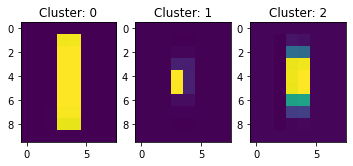

In [91]:
size=4
i=1
fig = plt.figure(figsize=(12,12))
for i in range(centers.shape[0]):
    fig.add_subplot(4, 6,i+1)
    plt.imshow(centers[i])
    plt.title("Cluster: "+str(labels_s[i]))
#     for k in range(4):
#         plt.title("Cluster: "+str(label))
#         fig.add_subplot(size, size,i)
#         plt.imshow(ob)
#         i+=1
plt.savefig('Pong_clusters.png')

In [592]:
#%tensorboard --logdir summaries/summary-20220502-150216

# stability of methods

# Clustering

# test PCA

In [92]:
state_list=np.load("Pong_Example_Run.npy")

In [594]:
Graphs=[]
Label_imgs=[]
emb=[]
for state in state_list:
    label_img,regions,labels,graph,emmbedding=custom.preprocess_state(state)
    Graphs.append(graph)
    Label_imgs.append(label_img)
    emb.append(emmbedding)

In [595]:
custom.pca_obj.explained_variance_ratio_.sum()

0.9966134823377953

In [596]:
custom.pca_obj.explained_variance_ratio_[0:2].sum()

0.8799287963981016

# test Birch

In [597]:
len(custom.birch_stab_acc)

1

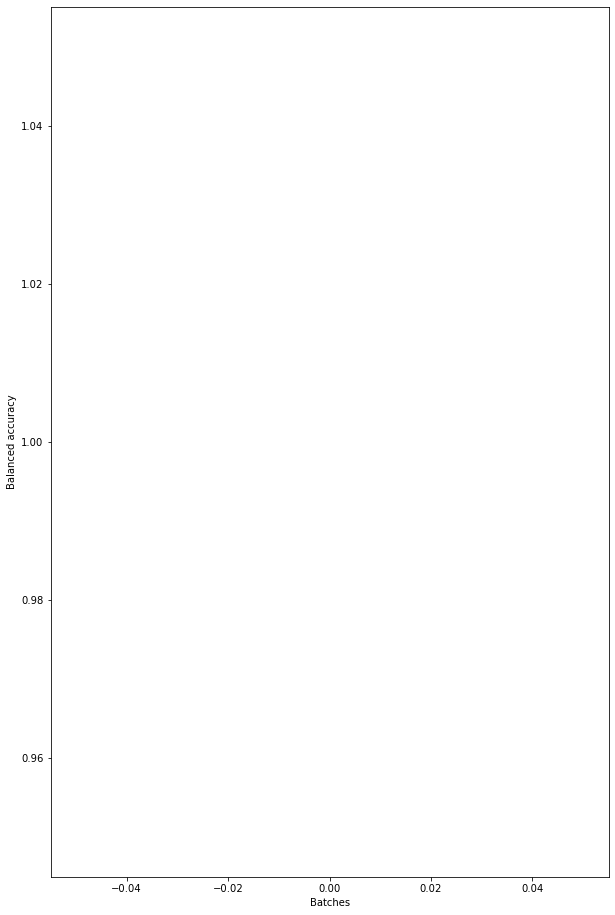

In [598]:
fig = plt.figure(figsize=(10,16))
sns.lineplot(x=np.arange(len(custom.birch_stab_acc)),y=custom.birch_stab_acc)
plt.xlabel("Batches")
plt.ylabel("Balanced accuracy")
plt.savefig('Pong_birch_stab.png')

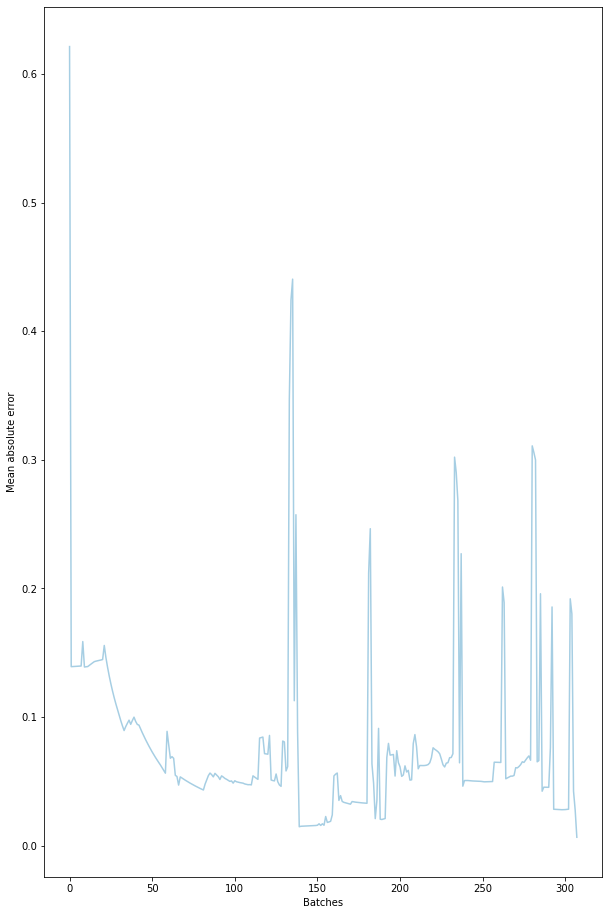

In [599]:
fig = plt.figure(figsize=(10,16))
sns.lineplot(x=np.arange(len(custom.pca_stab_err)),y=custom.pca_stab_err)
plt.xlabel("Batches")
plt.ylabel("Mean absolute error")
plt.savefig('Pong_pca_stab.png')

In [600]:
object_list=[]
for state in state_list:
    label_image, objects, regions=find_cut_objects(state[16:98,8:72],custom.max_obj_height,custom.max_obj_width)
    X=objects.reshape(objects.shape[0],-1)
    object_list.append(X.copy())

In [601]:
len(object_list)

1188

In [602]:
obj=object_list

In [603]:
obj=np.concatenate(obj)

In [604]:
obj.shape

(13045, 80)

In [605]:
obj=custom.pca_obj.transform(obj)

In [606]:
lab=custom.image_seg.predict(obj)

In [607]:
metrics.silhouette_score(obj, lab, metric='euclidean')

0.8907115687024169

In [608]:
metrics.davies_bouldin_score(obj, lab)

0.5406128499768523

In [609]:
d = euclidean_distances(obj[::10])

dunn.dunn(lab[::10],d)

0.173458857314439

In [610]:
np.unique(lab)

array([ 0,  2,  3,  4,  5,  6,  7,  8, 10, 12, 14])

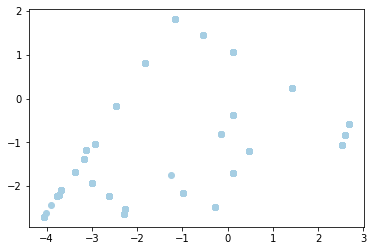

In [611]:
plt.scatter(obj[:,0],obj[:,1])

In [612]:
# X_embedded = TSNE(n_components=2, init='random').fit_transform(obj)

# df = pd.DataFrame(np.concatenate((X_embedded[:,:2],lab.reshape(-1,1)),axis=-1), columns=["x", "y","z"])
# df["z"]=df["z"].astype("int").astype("str")

In [613]:
df = pd.DataFrame(np.concatenate((obj[:,:2],lab.reshape(-1,1)),axis=-1), columns=["x", "y","z"])
df["z"]=df["z"].astype("int").astype("str")

In [614]:
df["z"]=df["z"].astype("int")

In [615]:
df=df.sort_values(["z"])

In [616]:
df["Class"]=df["z"].astype("str")

In [617]:
sns.set_palette("Paired")

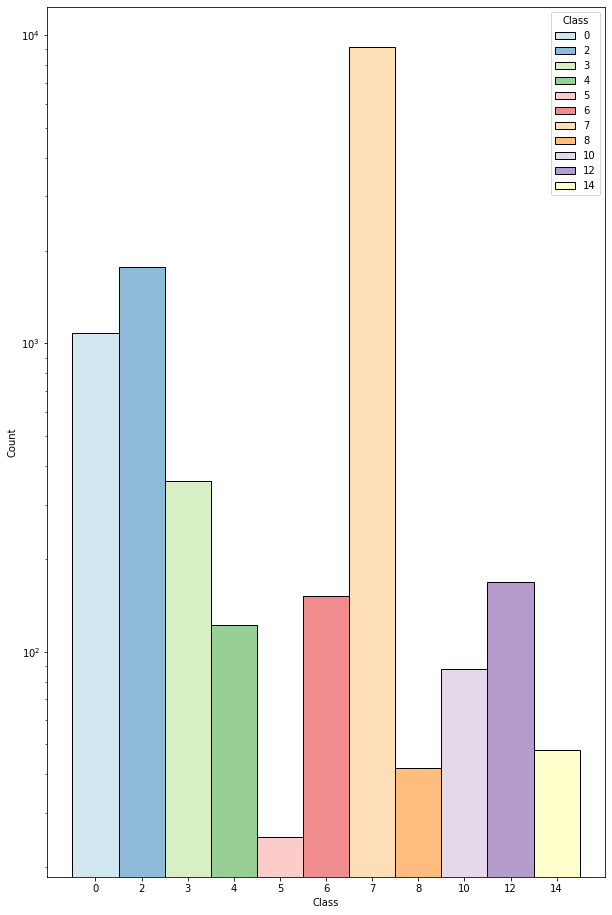

In [618]:
fig = plt.figure(figsize=(10,16))
sns.histplot(data=df,x="Class",hue="Class").set_yscale("log")
plt.savefig('Pong_hist.png')

In [619]:
df3=df

In [620]:
df4=df3.groupby(["x","y","Class"]).count()

In [621]:
df5=df4.groupby(["Class"]).apply(lambda x: 100 * x / float(x.sum())).reset_index()

In [622]:
df5["size"]=df5["z"]

In [623]:
df5["Class"]=df5["Class"].astype("int")

In [624]:
df5=df5.sort_values(["Class"])

In [625]:
df5["Class"]=df5["Class"].astype("str")

In [626]:
df6=df5.loc[df5["size"]>2]

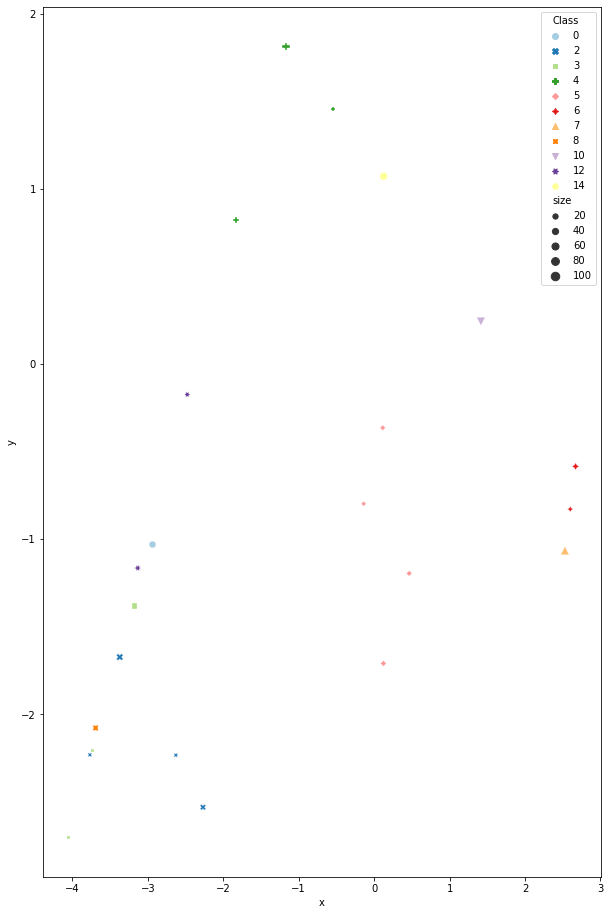

In [627]:
fig = plt.figure(figsize=(10,16))
sns.scatterplot(data=df6,x="x",y="y",hue="Class",style="Class",size="size")
plt.savefig('Pong_scatter_size.png')

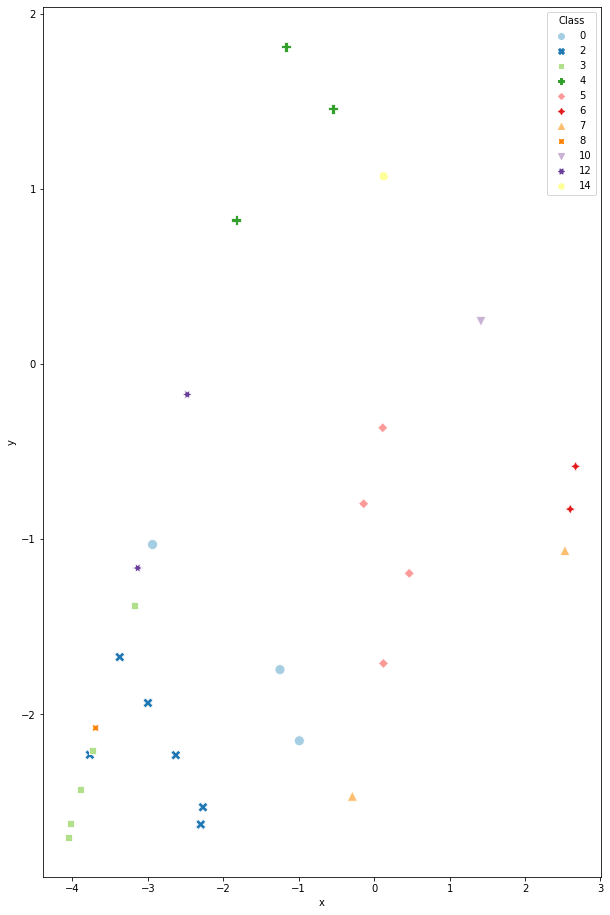

In [628]:
fig = plt.figure(figsize=(10,16))
sns.scatterplot(data=df,x="x",y="y",hue="Class",style="Class",s=100)
plt.savefig('Pong_scatter.png')

# test semantic model

In [629]:
custom.semantic_model.corpus_count

20000

In [630]:
len(custom.graph_list)

20000

In [631]:
train_corpus=custom.document_list
model=custom.semantic_model

In [632]:
%%time
ranks = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=1)
    ranks.append(sims[0][0])

CPU times: user 11min 25s, sys: 23min 59s, total: 35min 24s
Wall time: 4min 55s


In [633]:
similiar=np.array([x==ranks[x] for x in range(len(ranks))])

In [634]:
similiar.mean()

0.8704

In [635]:
wrong=np.argwhere(similiar==False)

In [636]:
g_diff=np.array([graph_diff(custom.graph_list[ranks[w[0]]],custom.graph_list[w[0]]) for w in wrong])

In [637]:
np.max(g_diff)

201.0

In [638]:
(g_diff==0).mean()

0.873070987654321

In [639]:
similiar.mean()+(1-similiar.mean())*(g_diff==0).mean()

0.98355

In [640]:
similiar.mean()+(1-similiar.mean())*(g_diff<5).mean()

0.987

In [641]:
worst=np.argmax(g_diff)

In [642]:
worst

803

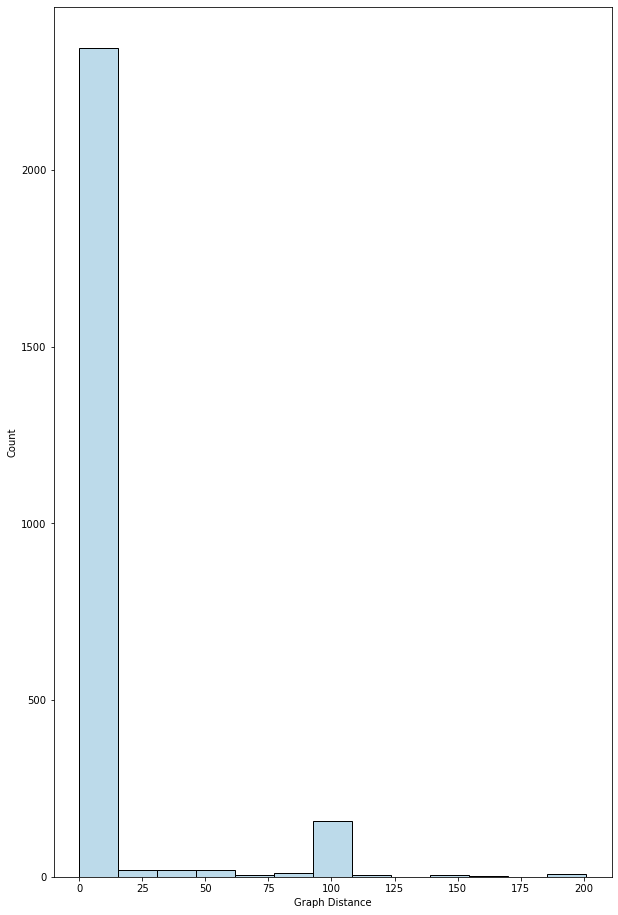

In [643]:
fig = plt.figure(figsize=(10,16))
sns.histplot(g_diff[g_diff<10000])
plt.xlabel("Graph Distance")
plt.savefig('Pong_semantic_train_hist_tragedy.png')

In [644]:
G1=custom.graph_list[ranks[wrong[worst][0]]]

In [645]:
G2=custom.graph_list[wrong[worst][0]]

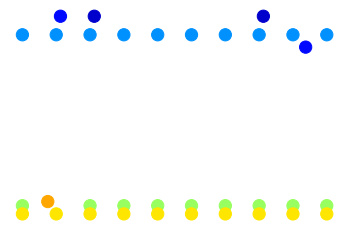

In [646]:
visualize_graph(G1)

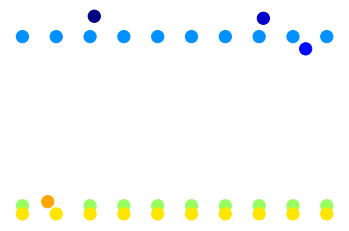

In [647]:
visualize_graph(G2)

In [648]:
graph_diff(G1,G2)

201.0

In [649]:
#test on movie

In [650]:
custom.document_list[100].words

['2',
 'pos_x5',
 'pos_y12',
 'apr_pos_x1',
 'apr_pos_y2',
 '2pos_x5',
 '2pos_y12',
 '2apr_pos_x1',
 '2apr_pos_y2',
 '0',
 'pos_x5',
 'pos_y20',
 'apr_pos_x1',
 'apr_pos_y4',
 '0pos_x5',
 '0pos_y20',
 '0apr_pos_x1',
 '0apr_pos_y4',
 '1',
 'pos_x5',
 'pos_y60',
 'apr_pos_x1',
 'apr_pos_y12',
 '1pos_x5',
 '1pos_y60',
 '1apr_pos_x1',
 '1apr_pos_y12',
 '2',
 'pos_x72',
 'pos_y70',
 'apr_pos_x14',
 'apr_pos_y14',
 '2pos_x72',
 '2pos_y70',
 '2apr_pos_x14',
 '2apr_pos_y14',
 '4',
 'pos_x14',
 'pos_y3',
 'apr_pos_x2',
 'apr_pos_y0',
 '4pos_x14',
 '4pos_y3',
 '4apr_pos_x2',
 '4apr_pos_y0',
 '4',
 'pos_x14',
 'pos_y11',
 'apr_pos_x2',
 'apr_pos_y2',
 '4pos_x14',
 '4pos_y11',
 '4apr_pos_x2',
 '4apr_pos_y2',
 '4',
 'pos_x14',
 'pos_y19',
 'apr_pos_x2',
 'apr_pos_y3',
 '4pos_x14',
 '4pos_y19',
 '4apr_pos_x2',
 '4apr_pos_y3',
 '4',
 'pos_x14',
 'pos_y27',
 'apr_pos_x2',
 'apr_pos_y5',
 '4pos_x14',
 '4pos_y27',
 '4apr_pos_x2',
 '4apr_pos_y5',
 '4',
 'pos_x14',
 'pos_y35',
 'apr_pos_x2',
 'apr_pos_y7'

In [651]:
ranks2=[]

In [652]:
for x in emb:
    sims = model.dv.most_similar([x], topn=1)
    ranks2.append(sims[0][0])

In [653]:
valid_diff=np.array([graph_diff(Graphs[i],custom.graph_list[ranks2[i]]) for i in range(len(ranks2))])

In [654]:
np.mean(valid_diff<10)

0.3846801346801347

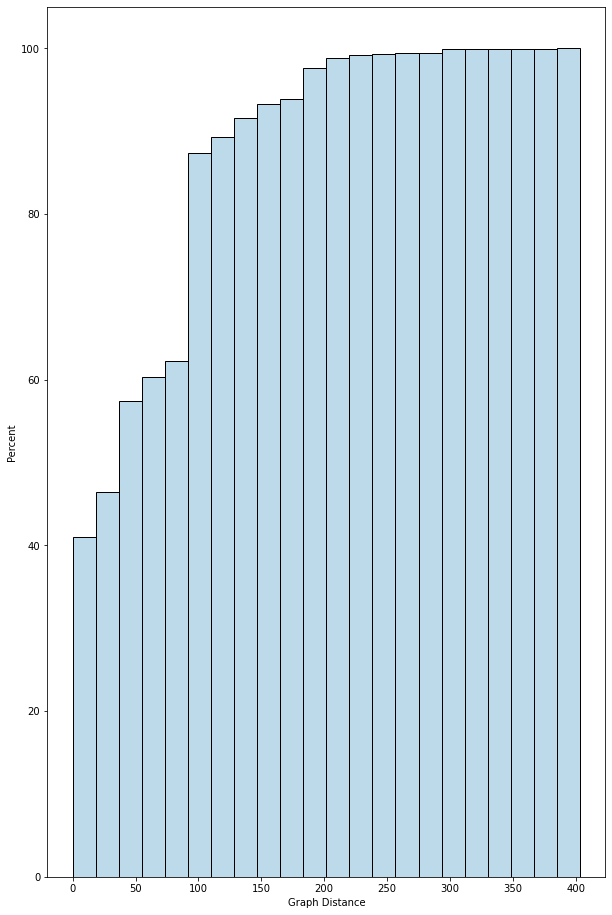

In [655]:
fig = plt.figure(figsize=(10,16))
sns.histplot(valid_diff,cumulative=True,stat="percent")
plt.xlabel("Graph Distance")
plt.savefig('Pong_semantic_val_cum_hist.png')

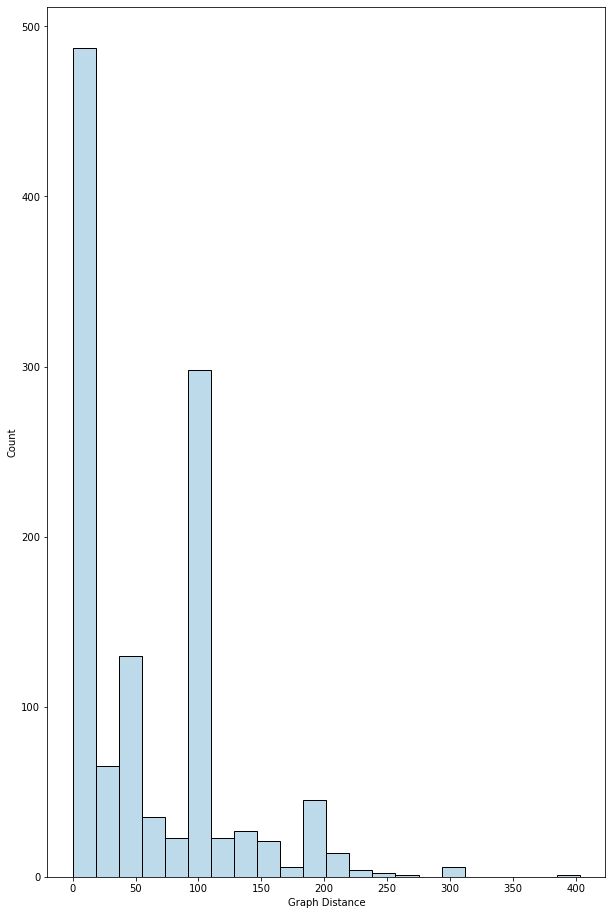

In [656]:
fig = plt.figure(figsize=(10,16))
sns.histplot(valid_diff)
plt.xlabel("Graph Distance")
plt.savefig('Pong_semantic_val_hist.png')

In [657]:
worst=np.argmax(valid_diff)

In [658]:
show_image(obj2[worst])

NameError: name 'obj2' is not defined

In [ ]:
temp=np.array(Label_imgs)

In [ ]:
np.argmax(temp[:,100,0])

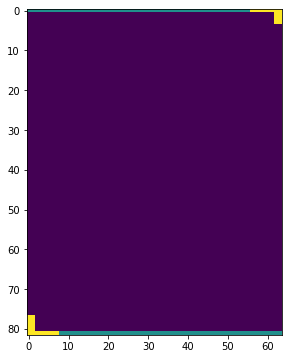

In [531]:
show_image(Label_imgs[133])

In [532]:
visualize_objects(find_cut_objects(obj2[133],20,16)[0],obj2[133])

NameError: name 'obj2' is not defined

In [533]:
Label_imgs[0].shape

(82, 64)

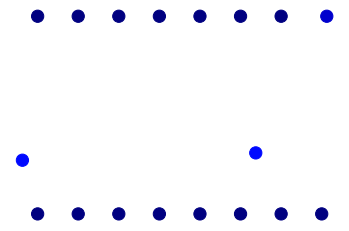

In [534]:
visualize_graph(Graphs[120])

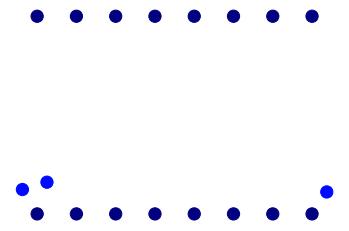

In [535]:
visualize_graph(custom.graph_list[ranks2[worst]])

In [536]:
best=np.argmin(valid_diff)

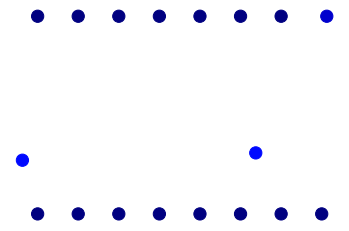

In [537]:
#fig = plt.figure(figsize=(10,16))
visualize_graph(Graphs[120])

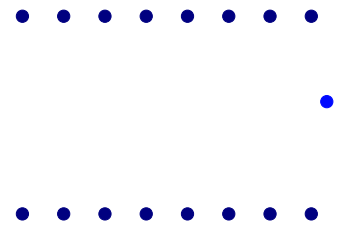

In [538]:
visualize_graph(custom.graph_list[ranks2[best]])

# Get best

In [539]:
def node_dist(n1,n2,obj_class_diff=100):
    return (n1[0]!=n2[0])*obj_class_diff+np.sqrt((n1[1]-n2[1])**2+(n1[2]-n2[2])**2)

def graph_metric(dist,obj_n_diff=100):
    return np.sum(np.min(dist,axis=1))+abs(dist.shape[0]-dist.shape[1])*obj_n_diff

def graph_diff2(G1,G2,obj_class_diff=100,obj_n_diff=100):
    l1=[(G1.nodes[x]["feature"],G1.nodes[x]["position_x"],G1.nodes[x]["position_y"]) for x in G1.nodes]
    l2=[(G2.nodes[x]["feature"],G2.nodes[x]["position_x"],G2.nodes[x]["position_y"]) for x in G2.nodes]
    
    if len(l1)==0 or len(l2)==0:
        return abs(len(l1)-len(l2))*obj_n_diff
    
    if len(l1)>len(l2):
        l1,l2 = l2,l1
    
    dist=np.zeros((len(l1),len(l2)))
    for x in range(len(l1)):
        for y in range(len(l2)):
            dist[x,y]=node_dist(l1[x],l2[y],obj_class_diff=obj_class_diff)
            if dist[x,y]==0:
                break
        
    return graph_metric(dist,obj_n_diff=obj_n_diff)

In [540]:
def graph_diff2(l1,l2,obj_class_diff=100,obj_n_diff=100):

    if len(l1)==0 or len(l2)==0:
        return abs(len(l1)-len(l2))*obj_n_diff
    
    if len(l1)>len(l2):
        l1,l2 = l2,l1
    
    dist=np.zeros((len(l1),len(l2)))
    for x in range(len(l1)):
        for y in range(len(l2)):
            dist[x,y]=node_dist(l1[x],l2[y],obj_class_diff=obj_class_diff)
            if dist[x,y]==0:
                break
        
    return np.sum(np.min(dist,axis=1))+abs(dist.shape[0]-dist.shape[1])*obj_n_diff

In [541]:
def graph_diff_list(G1_list,G2_list,obj_class_diff=100,obj_n_diff=100):
    L1=[[(G1.nodes[x]["feature"],G1.nodes[x]["position_x"],G1.nodes[x]["position_y"]) for x in G1.nodes] for G1 in G1_list]
    L2=[[(G2.nodes[x]["feature"],G2.nodes[x]["position_x"],G2.nodes[x]["position_y"]) for x in G2.nodes] for G2 in G2_list]
    

    dist=np.zeros((len(L1),len(L2)))
    for x in range(len(L1)):
        for y in range(len(L2)):
            dist[x,y]=graph_diff3(L1[x],L2[y])
            if dist[x,y]==0:
                break
        
    return dist

In [542]:
def graph_diff3(l1,l2,obj_class_diff=100,obj_n_diff=100):

    if len(l1)==0 or len(l2)==0:
        return abs(len(l1)-len(l2))*obj_n_diff
    
    if len(l1)>len(l2):
        l1,l2 = l2,l1
    
    l1=np.array([[l[1],l[2]] for l in l1])
    l2=np.array([[l[1],l[2]] for l in l2])
    
    lab1=np.array([[int(l[0])] for l in l1])
    lab2=np.array([[int(l[0])] for l in l2])
    
    dist=euclidean_distances(l1,l2)+obj_class_diff*(euclidean_distances(lab1,lab2)>0)
    
        
    return np.sum(np.min(dist,axis=1))+abs(dist.shape[0]-dist.shape[1])*obj_n_diff

In [659]:
%time graph_diff(Graphs[10],custom.graph_list[12])

CPU times: user 2.85 ms, sys: 0 ns, total: 2.85 ms
Wall time: 2.76 ms


400.0

In [544]:
%time G_test=graph_diff_list(Graphs[0:100],custom.graph_list[0:1000])

CPU times: user 46.8 s, sys: 740 ms, total: 47.5 s
Wall time: 46.2 s


In [593]:
%time G_test=graph_diff_list(Graphs,custom.graph_list)

CPU times: user 1h 17min 4s, sys: 0 ns, total: 1h 17min 4s
Wall time: 1h 17min 4s


In [545]:
G_test2=np.min(G_test,axis=1)

In [546]:
np.mean(G_test2<200)

0.86

Text(0.5, 0, 'Graph Distance')

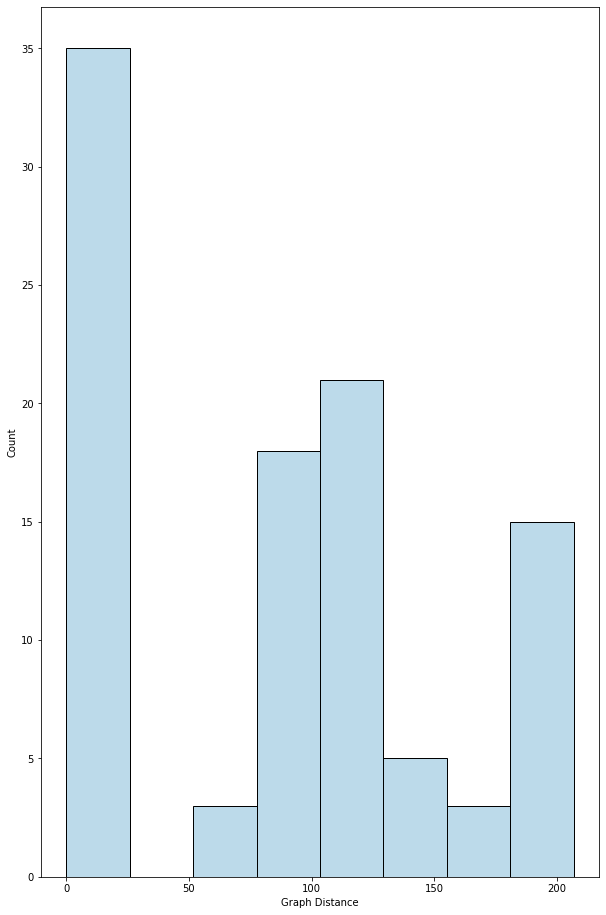

In [547]:
fig = plt.figure(figsize=(10,16))
sns.histplot(G_test2)
plt.xlabel("Graph Distance")

In [548]:
df_2=pd.DataFrame({"Distance":np.concatenate([valid_diff,G_test2]),"Embedding":np.concatenate([np.ones(len(valid_diff)),np.zeros(len(G_test2))])})

In [549]:
np.mean(valid_diff<200)/np.mean(G_test2<200)

1.1539816772374911

In [559]:
np.unique(valid_diff)

array([  0.        ,   1.        ,   2.        ,   2.23606798,
         2.41421356,   3.        ,   3.23606798,   4.        ,
         4.41421356,   5.        ,   5.09901951,   5.16227766,
         6.        ,   6.16227766,   6.70820393,   7.        ,
         7.24264069,   8.        ,   8.23606798,   8.94427191,
         9.        ,   9.60555128,  10.        ,  11.        ,
        12.        ,  12.64911064,  13.        ,  14.        ,
        15.        ,  16.        ,  17.        ,  18.        ,
        18.11077028,  19.        ,  19.03329638,  20.        ,
        20.39607805,  21.        ,  22.        ,  23.        ,
        25.        ,  25.55386468,  26.        ,  27.        ,
        28.        ,  29.        ,  33.        ,  34.        ,
        35.        ,  36.        ,  39.05124838,  40.        ,
        41.        ,  41.24621125,  44.        ,  47.        ,
        48.        ,  49.16227766,  50.        ,  52.23983155,
        53.19482701,  53.28427125,  54.        ,  55.  

In [550]:
np.concatenate([valid_diff,G_test2])

array([  0.,   0.,   0., ..., 101., 101., 105.])

In [551]:
np.concatenate([np.ones(len(valid_diff)),np.zeros(len(G_test2))])

array([1., 1., 1., ..., 0., 0., 0.])

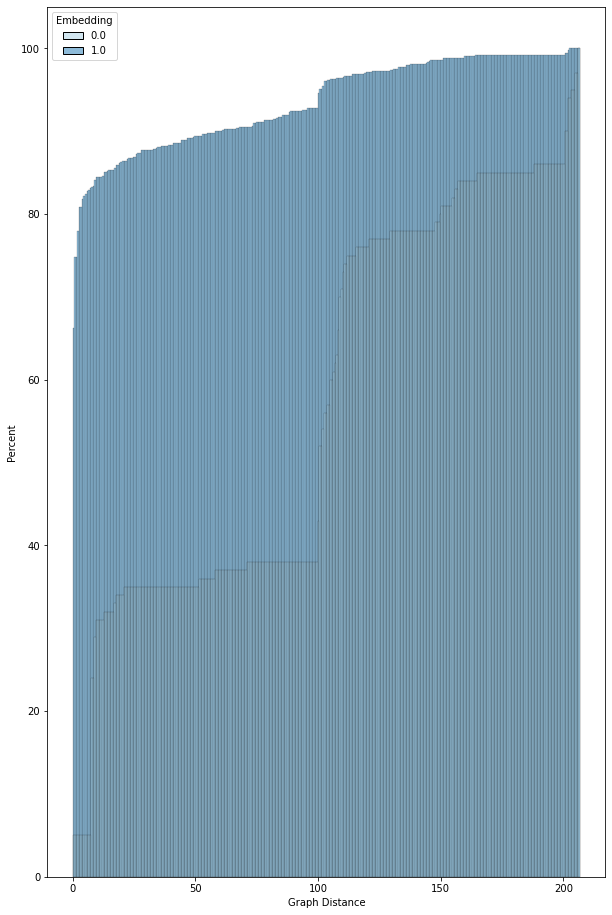

In [552]:
fig = plt.figure(figsize=(10,16))
sns.histplot(data=df_2,x="Distance",cumulative=True,stat="percent",hue="Embedding",common_norm=False)
plt.xlabel("Graph Distance")
plt.savefig('Pong_semantic_val_cum_hist.png')

# Tests

In [660]:
def cosine_similarity(x, y):
    
    # Ensure length of x and y are the same
    if len(x) != len(y) :
        return None
    
    # Compute the dot product between x and y
    dot_product = np.dot(x, y)
    
    # Compute the L2 norms (magnitudes) of x and y
    magnitude_x = np.sqrt(np.sum(x**2)) 
    magnitude_y = np.sqrt(np.sum(y**2))
    
    # Compute the cosine similarity
    cosine_similarity = dot_product / (magnitude_x * magnitude_y)
    
    return cosine_similarity

In [661]:
X=np.array(emb)

In [662]:
changes=(np.abs(X[1:]-X[0:-1])).mean(axis=-1)

In [663]:
changes=np.array([cosine_similarity(X[i+1],X[i]) for i in range(len(Graphs)-1)])

In [664]:
G_diff=np.array([graph_diff(Graphs[i],Graphs[i+1]) for i in range(len(Graphs)-1)])

In [665]:
m, b = np.polyfit(changes, G_diff, 1)

In [666]:
np.min(changes)

0.01043546

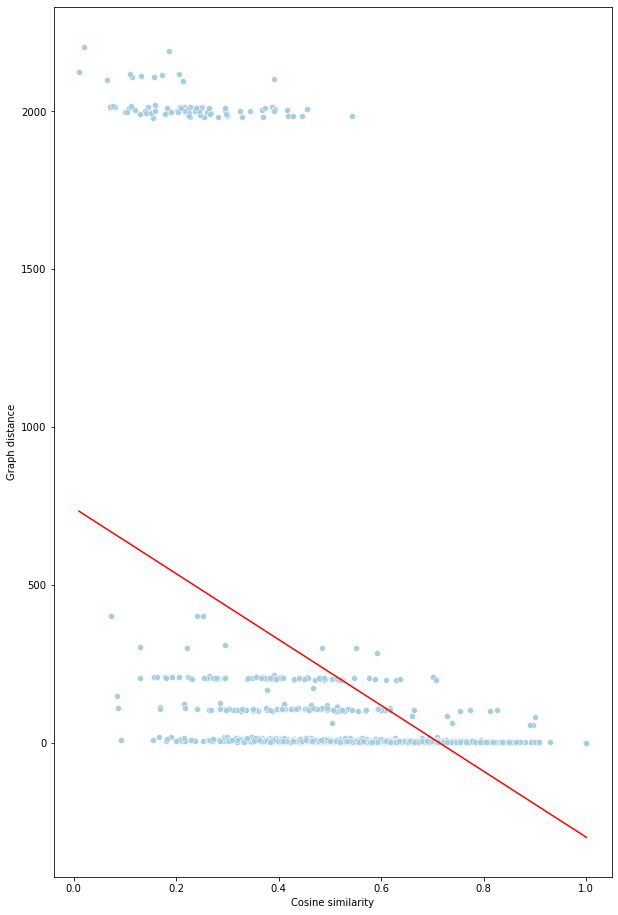

In [667]:
fig = plt.figure(figsize=(10,16))
sns.scatterplot(x=changes,y=G_diff)
plt.plot([np.min(changes),np.max(changes)], [np.min(changes)*m + b,np.max(changes)*m + b],c="red")
plt.xlabel("Cosine similarity")
plt.ylabel("Graph distance")
plt.savefig('Pong_val_correlation.png')

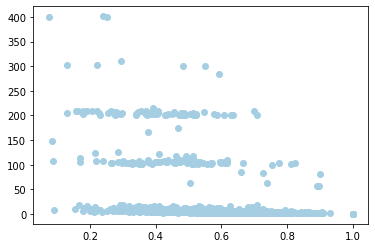

In [668]:
plt.scatter(changes[G_diff<500],G_diff[G_diff<500])

In [669]:
np.corrcoef(changes,G_diff)

array([[ 1.       , -0.4451673],
       [-0.4451673,  1.       ]])

In [670]:
np.corrcoef(changes[G_diff<1000],G_diff[G_diff<1000])

array([[ 1.        , -0.38027009],
       [-0.38027009,  1.        ]])

In [671]:
%time xd=[graph_diff(Graphs[100],G) for G in custom.graph_list]

CPU times: user 38.4 s, sys: 0 ns, total: 38.4 s
Wall time: 38.3 s


# other method

# Emmbedding

In [672]:
len(custom.semantic_model.wv)

748

In [673]:
custom.semantic_model.predict_output_word(custom.document_list[0])

RuntimeError: We have currently only implemented predict_output_word for the negative sampling scheme, so you need to have run word2vec with negative > 0 for this to work.

In [674]:
length, path = nx.single_source_dijkstra(G, 0,weight="weight")

path = dict(nx.all_pairs_dijkstra_path(G,weight="weight",cutoff=70))

nodes_near=[x for x in path[0]][1:5]

a=[G.nodes[x]["position_x"] for x in nodes_near]

b=[G.nodes[x]["position_y"] for x in nodes_near]

ind = np.lexsort((b,a))

np.array(a)[ind]

np.array(b)[ind]

NameError: name 'G' is not defined

In [675]:
len(emb)

1188

In [658]:
X=np.array(emb)

In [676]:
brc = Birch(n_clusters=32,threshold=0.5).fit(X)

In [677]:
lab=brc.labels_

In [678]:
metrics.silhouette_score(X, lab, metric='euclidean')

0.06430994

In [679]:
metrics.davies_bouldin_score(X, lab)

2.691350381595628

In [680]:
d = euclidean_distances(X)

dunn.dunn(lab,d)

0.31511125555223846

<AxesSubplot:xlabel='x', ylabel='y'>

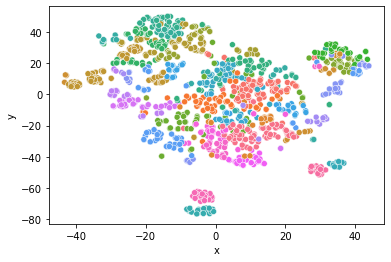

In [681]:
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

df = pd.DataFrame(np.concatenate((X_embedded[:,:2],lab.reshape(-1,1)),axis=-1), columns=["x", "y","z"])
df["z"]=df["z"].astype("int").astype("str")
sns.scatterplot(data=df,x="x",y="y",hue="z", legend=None)

In [682]:
np.unique(lab)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [683]:
Rewards=trace["reward"]

changes=np.where(lab[1:]!=lab[:-1])[0]

changes=np.concatenate(([0],changes,[len(Rewards)-1]))

NameError: name 'trace' is not defined

In [89]:
changes.shape

(120,)

In [107]:
G=nx.DiGraph()

In [130]:
df["x"][df.shape[0]-1]

2.8071489334106445

In [131]:
for c in range(1,len(changes)-1):
    G.add_nodes_from([(lab[changes[c]], {'position_x':df["x"][changes[c]], 'position_y':df["y"][changes[c]]})])
    G.add_nodes_from([(lab[changes[c+1]], {'position_x':df["x"][changes[c+1]], 'position_y':df["y"][changes[c+1]]})])
    G.add_edge(lab[changes[c]],lab[changes[c+1]], weight=-np.mean(Rewards[changes[c-1]:changes[c]])+100)

G.add_nodes_from([(-1, {'position_x':df["x"][df.shape[0]-1], 'position_y':df["y"][df.shape[0]-1]})])
G.add_edge(lab[changes[c+1]],-1, weight=-np.mean(Rewards[changes[c]:changes[c+1]])+100)

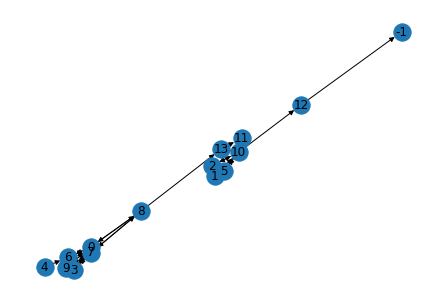

In [132]:
nx.draw(G,with_labels=True)

In [798]:
nx.shortest_path(G, source=0, target=-1, weight="weight", method='dijkstra')

[0, 1, 2, 3, 5, 19, 25, 27, -1]

In [115]:
G.nodes[0]['position_x']

-6.631448745727539

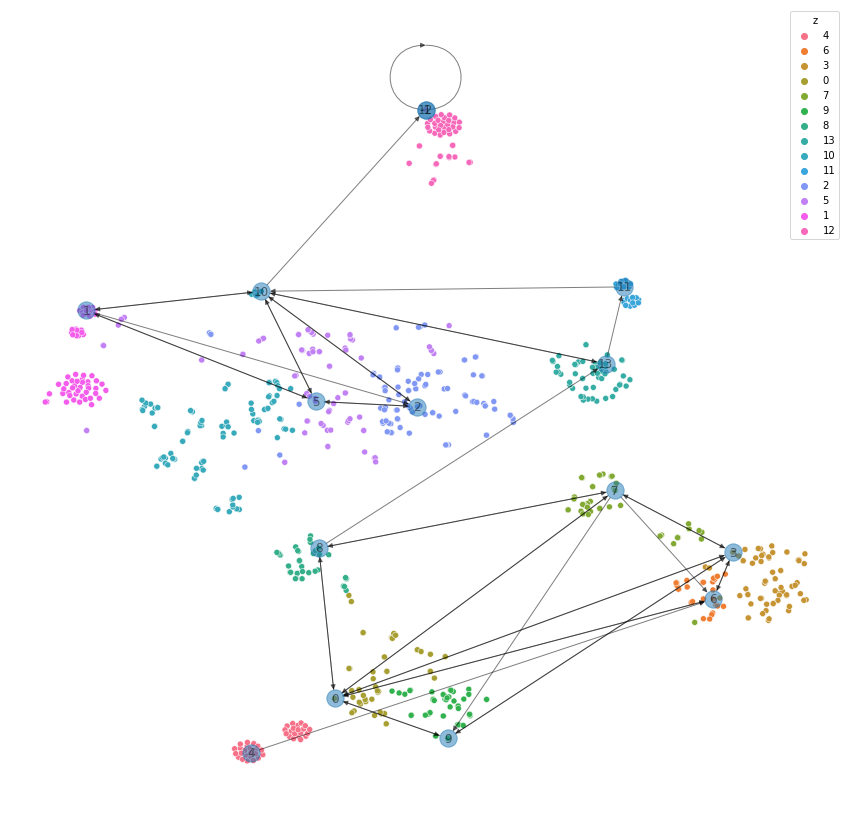

In [142]:
pos = nx.spring_layout(G)
for n in G.nodes():
    pos[n][0]=G.nodes[n]['position_x']
    pos[n][1]=G.nodes[n]['position_y']

plt.figure(figsize=(15,15))
sns.scatterplot(data=df,x="x",y="y",hue="z")
ec = nx.draw(G, pos, alpha=0.5,with_labels=True)
plt.show()

In [38]:
make_video(States[changes],"test2",fps=7)

# Trees

In [843]:
G=Graphs[100]

In [844]:
length, path = nx.single_source_dijkstra(G, 0,weight="weight")

path = dict(nx.all_pairs_dijkstra_path(G,weight="weight",cutoff=70))

nodes_near=[x for x in path[0]][1:5]

a=[G.nodes[x]["position_x"] for x in nodes_near]

b=[G.nodes[x]["position_y"] for x in nodes_near]

ind = np.lexsort((b,a))

np.array(a)[ind]

np.array(b)[ind]

array([ 3, 11, 19, 27])

In [845]:
nodes_near

[5, 4, 6, 3]

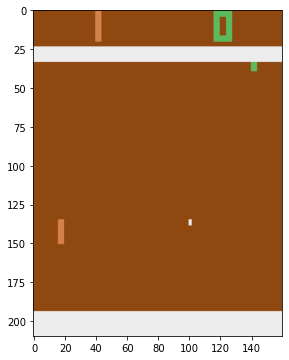

In [122]:
show_image(custom.state_list[116])

In [428]:
X=obj_mask

In [429]:
p_h=3
p_w=3
split_h=np.arange(p_h,105-p_h,2).astype("int")
split_w=np.arange(p_w,80-p_w,2).astype("int")

In [430]:
X2=np.zeros((episode_len,len(split_h)*len(split_w),2*p_h+1,2*p_w+1)).astype("int")

In [431]:
position=np.zeros((episode_len,len(split_h)*len(split_w),2))

In [432]:
action=np.zeros((episode_len,len(split_h)*len(split_w),1))

In [433]:
reward=np.zeros((episode_len,len(split_h)*len(split_w),1))

In [434]:
# for i in range(100):
#     j=0
#     for x in range(p_h-1):
#         for y in range(p_w-1):
#             X2[i,j,:,:]=X[i:i+1,split_h[x]:split_h[x+2],split_w[y]:split_w[y+2]]
#             j+=1

In [435]:
for i in range(episode_len):
    j=0
    for x in split_h:
        for y in split_w:
            X2[i,j,:,:]=X[i:i+1,x-p_h:x+p_h+1,y-p_w:y+p_w+1]
            position[i,j,0]=x
            position[i,j,1]=y
            action[i,j,0]=Actions[i]
            reward[i,j,0]=Rewards[i]
            j+=1

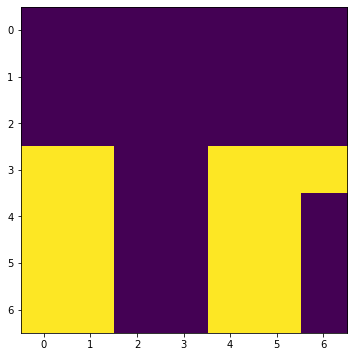

In [436]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(X2[6,68])

In [437]:
X2_prev=X2[0:-2]

X2_now=X2[1:-1]

X2_next=X2[2:]

In [438]:
X2_prev=X2_prev.reshape(-1,2*p_h+1,2*p_w+1).reshape(len(split_h)*len(split_w)*(episode_len-2),-1)

In [439]:
X2_now=X2_prev.reshape(-1,2*p_h+1,2*p_w+1).reshape(len(split_h)*len(split_w)*(episode_len-2),-1)

In [440]:
X2_next=X2_next.reshape(-1,2*p_h+1,2*p_w+1)[:,p_h:p_h+1,p_w:p_w+1].reshape(len(split_h)*len(split_w)*(episode_len-2),)

In [441]:
position_prev=position[0:-2]

position_now=position[1:-1]

position_prev=position_prev.reshape(-1,2)

position_now=position_now.reshape(-1,2)

In [442]:
action_prev=action[0:-2]

action_now=action[1:-1]

action_prev=action_prev.reshape(-1,1)

action_now=action_now.reshape(-1,1)

In [443]:
reward_prev=reward[0:-2]

reward_now=reward[1:-1]

reward_prev=reward_prev.reshape(-1,1)

reward_now=reward_now.reshape(-1,1)

In [444]:
#prev_state positionx positiony action time reward?

In [445]:
nominal_attributes=np.arange(2*X2_prev.shape[1]+2).astype("int")

In [446]:
nominal_attributes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [447]:
state=np.hstack((action_prev,action_now,X2_prev,X2_now,position_now,reward_prev,reward_now))

In [448]:
state.shape

(1467050, 104)

In [394]:
lc_ht = VeryFastDecisionRulesClassifier(nominal_attributes=nominal_attributes)

In [395]:
%time lc_ht.partial_fit(state,X2_next)

CPU times: user 9min 43s, sys: 691 ms, total: 9min 44s
Wall time: 9min 49s


VeryFastDecisionRulesClassifier(drift_detector=None, expand_confidence=1e-07,
                                expand_criterion='info_gain', grace_period=200,
                                max_rules=1000, min_weight=100,
                                nb_prediction=True, nb_threshold=0,
                                nominal_attributes=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                ordered_rules=True, remove_poor_atts=False,
                                rule_prediction='first_hit',
                                tie_threshold=0.05)

In [381]:
# lc_ht = HoeffdingTreeClassifier(nominal_attributes=nominal_attributes)

In [382]:
# %time lc_ht.partial_fit(state[::1000],X2_next[::1000])

CPU times: user 4.58 s, sys: 0 ns, total: 4.58 s
Wall time: 4.58 s


HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                        leaf_prediction='nba', max_byte_size=33554432,
                        memory_estimate_period=1000000, nb_threshold=0,
                        no_preprune=False,
                        nominal_attributes=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                        remove_poor_atts=False, split_confidence=1e-07,
                        split_criterion='info_gain', stop_mem_management=False,
                        tie_threshold=0.05)

In [390]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32)
])

In [391]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [393]:
%time model.fit(state[::1000],X2_next[::1000], epochs=10)

Epoch 1/10
46/46 [==============================] - 0s 1ms/step - loss: 0.2860 - accuracy: 0.9292
Epoch 2/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1828 - accuracy: 0.9469
Epoch 3/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1399 - accuracy: 0.9564
Epoch 4/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1130 - accuracy: 0.9680
Epoch 5/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1088 - accuracy: 0.9619
Epoch 6/10
46/46 [==============================] - 0s 1ms/step - loss: 0.0869 - accuracy: 0.9707
Epoch 7/10
46/46 [==============================] - 0s 1ms/step - loss: 0.1051 - accuracy: 0.9707
Epoch 8/10
46/46 [==============================] - 0s 1ms/step - loss: 0.0740 - accuracy: 0.9796
Epoch 9/10
46/46 [==============================] - 0s 1ms/step - loss: 0.0861 - accuracy: 0.9775
Epoch 10/10
46/46 [==============================] - 0s 1ms/step - loss: 0.0713 - accuracy: 0.9809
CPU times: user 1.0

In [397]:
%time Y=lc_ht.predict(state[::1000])

CPU times: user 1.94 s, sys: 4.07 ms, total: 1.94 s
Wall time: 1.94 s


/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/skmultiflow/rules/very_fast_decision_rules.py:837: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(predictions)


In [ ]:
Y

In [ ]:
Y2=X2_next

In [ ]:
np.mean(Y2==Y)

In [ ]:
for x in np.unique(Y2):
    print(str(x)+":"+str(np.mean(Y2[Y2==x]==Y[Y2==x]))+" N:"+str(np.sum(Y2==x)))

In [398]:
print(lc_ht.get_model_description())

Rule 0 :Att (75) = 0.000 and Att (99) = 0.000 and Att (100) <= 84.820 and Att (73) = 17.000| class :0  {0: 9866.0, 10: 2.0, 17: 171.0, 25: 2.0, 31: 1.0}
Rule 1 :Att (75) = 0.000 and Att (67) = 0.000 and Att (69) = 0.000 and Att (101) <= 9.550 and Att (100) <= 11.550 and Att (1) != 5.000| class :0  {0: 3035.0, 8: 8.0}
Rule 2 :Att (100) <= 39.910 and Att (75) = 0.000 and Att (74) = 2.000| class :0  {0: 5585.0, 2: 172.0, 5: 1.0}
Rule 3 :Att (75) = 0.000 and Att (76) = 0.000 and Att (66) = 0.000 and Att (101) <= 16.820 and Att (100) <= 11.360 and Att (0) != 0.000| class :0  {0: 2413.0, 8: 2.0}
Rule 4 :Att (75) = 0.000 and Att (66) = 0.000 and Att (68) != 0.000| class :0  {0: 18615.0, 2: 23.0, 5: 399.0, 8: 6.0, 9: 273.0, 10: 24.0, 14: 1.0, 16: 1.0, 17: 185.0, 18: 1.0, 20: 1.0, 23: 4.0, 25: 261.0, 29: 54.0}
Rule 5 :Att (100) <= 7.910 and Att (75) = 0.000 and Att (67) = 0.000 and Att (101) <= 15.000| class :0  {0: 1359.4968314802538, 8: 2.0}
Rule 6 :Att (75) = 0.000 and Att (82) = 0.000 and A

In [399]:
print(lc_ht.get_rules_description())

AttributeError: 'VeryFastDecisionRulesClassifier' object has no attribute 'get_rules_description'

In [400]:
len(lc_ht.get_model_rules())

21

In [401]:
print(lc_ht.get_model_description())

Rule 0 :Att (75) = 0.000 and Att (99) = 0.000 and Att (100) <= 84.820 and Att (73) = 17.000 | class: 0| class :0  {0: 9866.0, 10: 2.0, 17: 171.0, 25: 2.0, 31: 1.0}
Rule 1 :Att (75) = 0.000 and Att (67) = 0.000 and Att (69) = 0.000 and Att (101) <= 9.550 and Att (100) <= 11.550 and Att (1) != 5.000 | class: 0| class :0  {0: 3035.0, 8: 8.0}
Rule 2 :Att (100) <= 39.910 and Att (75) = 0.000 and Att (74) = 2.000 | class: 0| class :0  {0: 5585.0, 2: 172.0, 5: 1.0}
Rule 3 :Att (75) = 0.000 and Att (76) = 0.000 and Att (66) = 0.000 and Att (101) <= 16.820 and Att (100) <= 11.360 and Att (0) != 0.000 | class: 0| class :0  {0: 2413.0, 8: 2.0}
Rule 4 :Att (75) = 0.000 and Att (66) = 0.000 and Att (68) != 0.000 | class: 0| class :0  {0: 18615.0, 2: 23.0, 5: 399.0, 8: 6.0, 9: 273.0, 10: 24.0, 14: 1.0, 16: 1.0, 17: 185.0, 18: 1.0, 20: 1.0, 23: 4.0, 25: 261.0, 29: 54.0}
Rule 5 :Att (100) <= 7.910 and Att (75) = 0.000 and Att (67) = 0.000 and Att (101) <= 15.000 | class: 0| class :0  {0: 1359.49683148

In [402]:
r=lc_ht.get_model_rules()[2]

In [403]:
r.predicate_set

[Predicate(att_idx=100, operator='<=', value=39.90909090909091),
 Predicate(att_idx=75, operator='=', value=0.0),
 Predicate(att_idx=74, operator='=', value=2.0)]

In [467]:
p_h=3
p_w=3
split_h=np.arange(p_h,105-p_h,1).astype("int")
split_w=np.arange(p_w,80-p_w,1).astype("int")

In [468]:
split_w

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76])

In [469]:
k=500

In [470]:
obj_mask[0]

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [19, 19, 19, ..., 19, 19, 19],
       [19, 19, 19, ..., 19, 19, 19],
       [19, 19, 19, ..., 19, 19, 19]], dtype=int8)

In [471]:
X2_prev=obj_mask[k:k+1][0]

X2_now=obj_mask[k+1:k+2][0]

X2_next=obj_mask[k+2:k+3][0]

action_prev=Actions[k:k+1][0]

action_now=Actions[k+1:k+2][0]

reward_prev=Rewards[k:k+1][0]

reward_now=Rewards[k+1:k+2][0]

In [472]:
X2_prev.shape

(105, 80)

In [473]:
Y=X2_now.copy()

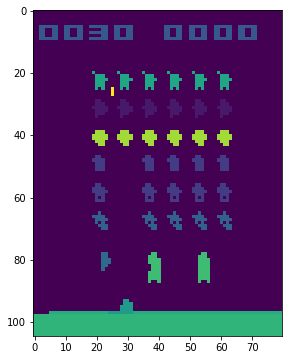

In [474]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(X2_now)

In [475]:
state.shape

(90,)

In [476]:
x

3

In [477]:
y

77

In [478]:
for x in split_h:
    for y in split_w:
        state=np.hstack((action_prev,action_now,X2_prev[x-p_h:x+p_h+1,y-p_w:y+p_w+1].reshape(-1),X2_now[x-p_h:x+p_h+1,y-p_w:y+p_w+1].reshape(-1),np.array([x,y]),reward_prev,reward_now))
        Y[x-p_h:x+p_h+1,y-p_w:y+p_w+1]=lc_ht.predict(state.reshape(1,-1))

In [479]:
np.mean(Y[X2_next!=0]==X2_next[X2_next!=0])

0.45925925925925926

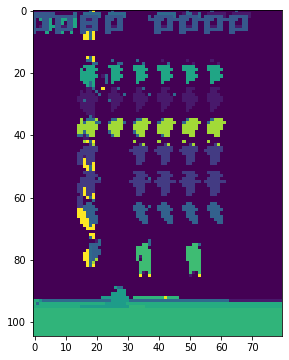

In [480]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(Y)

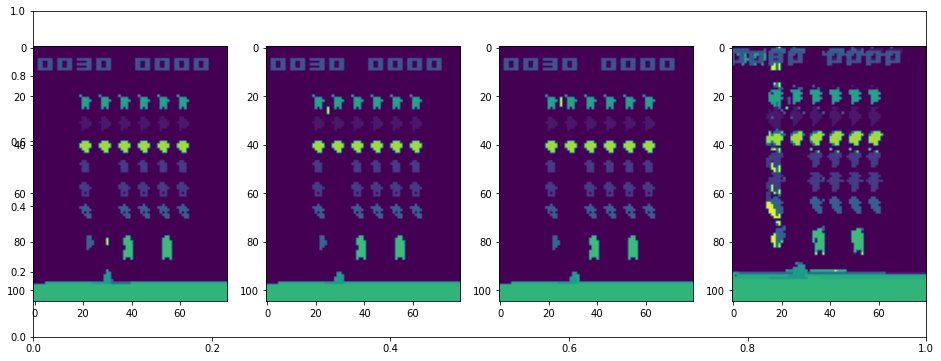

In [481]:
fig, ax = plt.subplots(figsize=(16, 6))
fig.add_subplot(1,4,1)
plt.imshow(X2_prev)
fig.add_subplot(1,4,2)
plt.imshow(X2_now)
fig.add_subplot(1,4,3)
plt.imshow(X2_next)
fig.add_subplot(1,4,4)
plt.imshow(Y)

# Ontology

In [396]:
onto = owl.get_ontology("http://test.org/onto.owl")

In [84]:
onto

get_ontology("http://test.org/onto.owl#")

In [436]:
class State(owl.Thing):
    namespace = onto

In [437]:
class Action(owl.Thing):
    namespace = onto

In [438]:
class from_state_action(owl.ObjectProperty):
    namespace = onto
    domain = [State]
    range  = [Action]

In [439]:
class to_state_action(owl.ObjectProperty):
    namespace = onto
    domain = [Action]
    range  = [State]

In [445]:
with onto:
    class object_representant(owl.DataProperty):
        domain = [Object]
        range = [str]

In [449]:
with onto:
    class object_position_x(owl.DataProperty):
        domain = [Object]
        range = [int]

In [450]:
with onto:
    class object_position_y(owl.DataProperty):
        domain = [Object]
        range = [int]

In [446]:
class Object(owl.Thing):
    namespace = onto

In [460]:
regions[0].bbox

(10, 4, 19, 16)

In [464]:
kmeans.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4,
       0, 0, 0], dtype=int32)

In [466]:
my_object = Object("my_object", namespace = onto, object_representant = ["rep"],object_position_x=[0],object_position_y=[0])

In [467]:
onto.my_object.get_properties()

{einsteins_riddle.object_representant,
 einsteins_riddle.object_position_x,
 einsteins_riddle.object_position_y}

# Reasoning

In [418]:
onto = owl.get_ontology("file://einsteins_riddle.rdf").load()

# Grounding

In [419]:
onto.name

'einsteins_riddle'

In [420]:
list(onto.classes())

[owl.Nothing,
 einsteins_riddle.owl.Beverage,
 einsteins_riddle.owl.Man,
 einsteins_riddle.owl.Color,
 einsteins_riddle.owl.House,
 einsteins_riddle.owl.Pet,
 einsteins_riddle.owl.Cigarette]

In [421]:
list(onto.individuals())

[einsteins_riddle.owl.orange_juice,
 einsteins_riddle.owl.tea,
 einsteins_riddle.owl.water,
 einsteins_riddle.owl.coffee,
 einsteins_riddle.owl.milk,
 einsteins_riddle.owl.Kools,
 einsteins_riddle.owl.Lucky_Strike,
 einsteins_riddle.owl.Parliaments,
 einsteins_riddle.owl.Chesterfields,
 einsteins_riddle.owl.Old_Gold,
 einsteins_riddle.owl.green,
 einsteins_riddle.owl.red,
 einsteins_riddle.owl.blue,
 einsteins_riddle.owl.yellow,
 einsteins_riddle.owl.ivory,
 einsteins_riddle.owl.house-2,
 einsteins_riddle.owl.house-3,
 einsteins_riddle.owl.house-1,
 einsteins_riddle.owl.house-4,
 einsteins_riddle.owl.house-5,
 einsteins_riddle.owl.Ukrainian,
 einsteins_riddle.owl.Spaniard,
 einsteins_riddle.owl.Norwegian,
 einsteins_riddle.owl.Englishman,
 einsteins_riddle.owl.Japanese,
 einsteins_riddle.owl.zebra,
 einsteins_riddle.owl.horse,
 einsteins_riddle.owl.snails,
 einsteins_riddle.owl.dog,
 einsteins_riddle.owl.fox]

In [422]:
list(onto.properties())

[einsteins_riddle.owl.drinks,
 einsteins_riddle.owl.has_color,
 einsteins_riddle.owl.lives_in,
 einsteins_riddle.owl.owns,
 einsteins_riddle.owl.right_to,
 einsteins_riddle.owl.smokes,
 1.1.description,
 1.1.date,
 1.1.creator]

In [423]:
list(onto.object_properties())

[einsteins_riddle.owl.drinks,
 einsteins_riddle.owl.has_color,
 einsteins_riddle.owl.lives_in,
 einsteins_riddle.owl.owns,
 einsteins_riddle.owl.right_to,
 einsteins_riddle.owl.smokes]

In [424]:
list(onto.disjoints())

[AllDisjoint([einsteins_riddle.owl.Chesterfields, einsteins_riddle.owl.Englishman, einsteins_riddle.owl.Japanese, einsteins_riddle.owl.Kools, einsteins_riddle.owl.Lucky_Strike, einsteins_riddle.owl.Norwegian, einsteins_riddle.owl.Old_Gold, einsteins_riddle.owl.Parliaments, einsteins_riddle.owl.Spaniard, einsteins_riddle.owl.Ukrainian, einsteins_riddle.owl.blue, einsteins_riddle.owl.coffee, einsteins_riddle.owl.dog, einsteins_riddle.owl.fox, einsteins_riddle.owl.green, einsteins_riddle.owl.horse, einsteins_riddle.owl.house-1, einsteins_riddle.owl.house-2, einsteins_riddle.owl.house-3, einsteins_riddle.owl.house-4, einsteins_riddle.owl.house-5, einsteins_riddle.owl.ivory, einsteins_riddle.owl.milk, einsteins_riddle.owl.orange_juice, einsteins_riddle.owl.red, einsteins_riddle.owl.snails, einsteins_riddle.owl.tea, einsteins_riddle.owl.water, einsteins_riddle.owl.yellow, einsteins_riddle.owl.zebra], ontology = get_ontology("http://persons.iis.nsk.su/files/persons/pages/einsteins_riddle.owl#

In [426]:
with onto:
    owl.sync_reasoner(infer_property_values = True)

* Owlready2 * Running HermiT...
    java -Xmx2000M -cp /home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/owlready2/hermit:/home/olaf/anaconda3/envs/master/lib/python3.9/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////tmp/tmpwhqkkfrx -Y


* Owlready * Adding relation einsteins_riddle.owl.Norwegian smokes einsteins_riddle.owl.Kools
* Owlready * Adding relation einsteins_riddle.owl.Ukrainian smokes einsteins_riddle.owl.Chesterfields
* Owlready * Adding relation einsteins_riddle.owl.Spaniard smokes einsteins_riddle.owl.Lucky_Strike
* Owlready * Adding relation einsteins_riddle.owl.Englishman smokes einsteins_riddle.owl.Old_Gold
* Owlready * Adding relation einsteins_riddle.owl.Norwegian owns einsteins_riddle.owl.fox
* Owlready * Adding relation einsteins_riddle.owl.Ukrainian owns einsteins_riddle.owl.horse
* Owlready * Adding relation einsteins_riddle.owl.Englishman owns einsteins_riddle.owl.snails
* Owlready * Adding relation einsteins_riddle.owl.Japanese owns einsteins_riddle.owl.zebra
* Owlready * Adding relation einsteins_riddle.owl.Norwegian drinks einsteins_riddle.owl.water
* Owlready * Adding relation einsteins_riddle.owl.Spaniard drinks einsteins_riddle.owl.orange_juice
* Owlready * Adding relation einsteins_riddle

* Owlready2 * HermiT took 1.7078933715820312 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [427]:
query = owl.default_world.prepare_sparql("""SELECT ?house ?man Where{ ?house a einsteins_riddle:House. ?man a einsteins_riddle:Man. ?man einsteins_riddle:lives_in ?house. 
}""")

In [428]:
list(query.execute())

[[einsteins_riddle.owl.house-2, einsteins_riddle.owl.Ukrainian],
 [einsteins_riddle.owl.house-4, einsteins_riddle.owl.Spaniard],
 [einsteins_riddle.owl.house-1, einsteins_riddle.owl.Norwegian],
 [einsteins_riddle.owl.house-1, einsteins_riddle.owl.Norwegian],
 [einsteins_riddle.owl.house-3, einsteins_riddle.owl.Englishman],
 [einsteins_riddle.owl.house-5, einsteins_riddle.owl.Japanese]]